# Hypothesis Testing  with Insurance Data

Author: Paul Foy

## Imports and load data

In [1]:
# Imports
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy
scipy.__version__

'1.9.3'

In [2]:
#Load data
df = pd.read_csv('Data/insurance - insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Test 1: Do smokers have higher insurance charges than non-smokers?

### Hypothesis: 

- H<sub>0</sub>: There is no difference in charges between smokers and non-smokers.

- H<sub>a</sub>: Charges for smokers are higher than non-smokers
  
### Determine Test Type: 

-  Numerical Data
- Two groups/samples
- We want to run a 2-sample T-test. 

### Assumptions:
- No significant outliers
- Normally distributed groups
- Equal Variance between groups

### Check for any significant outliers

In [3]:
## check the col that contains the measurement
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [4]:
## check the col that contains info on the groups
df['smoker']#.describe()

0       yes
1        no
2        no
3        no
4        no
       ... 
1333     no
1334     no
1335     no
1336     no
1337    yes
Name: smoker, Length: 1338, dtype: object

In [5]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
## save list of columns needed for each group
smoker_charges = df.loc[df['smoker'] == 'yes', "charges"]
nonsmoker_charges = df.loc[df['smoker'] == 'no', "charges"]

In [7]:
#Check for outliers in smokers
zscores_smoker = stats.zscore(smoker_charges)
outliers_smoker = abs(zscores_smoker)>3
np.sum(outliers_smoker)

0

In [8]:
#Check for outliers in non-smokers
zscores_nonsmoker = stats.zscore(nonsmoker_charges)
outliers_nonsmoker = abs(zscores_nonsmoker)>3
np.sum(outliers_nonsmoker)

24

In [9]:
#Remove outliers in non-smokers group
nonsmoker_charges = nonsmoker_charges[(np.abs(stats.zscore(nonsmoker_charges)) < 3)]

### Test for normality

In [10]:
## Check smoker group for normality
result = stats.normaltest(smoker_charges)
result.pvalue

5.564930630036463e-14

In [11]:
## Check n for smoker group
len(smoker_charges)

274

In [12]:
## Check non-smoker group for normality
result = stats.normaltest(nonsmoker_charges)
result.pvalue

2.6945416315543976e-36

In [13]:
## Check n for non-smoker group
len(nonsmoker_charges)

1040

Note: We have large enough groups that we can safely disregard the assumption of normality.

### Test for equal variances

In [14]:
#Test for equal variance
result = stats.levene(smoker_charges, nonsmoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

We met the assumption of normality but did NOT meet the assumption of equal variance.
We will therefore run a Welch's t-test instead by adding equal_var=False to stats.ttest_ind

### Final Hypothesis Test - T-Test

In [15]:
result = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var=False)
print(result)
result.pvalue  < .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


True

In [16]:
smoker_charges.mean()

32050.23183153284

In [17]:
nonsmoker_charges.mean()

7939.8608446721155

We had a p-value < .05 for our welch's t-test. We reject the null hypothesis and support the alternative that there is a significant difference between smokers and non-smokers. 

### Supporting Visual

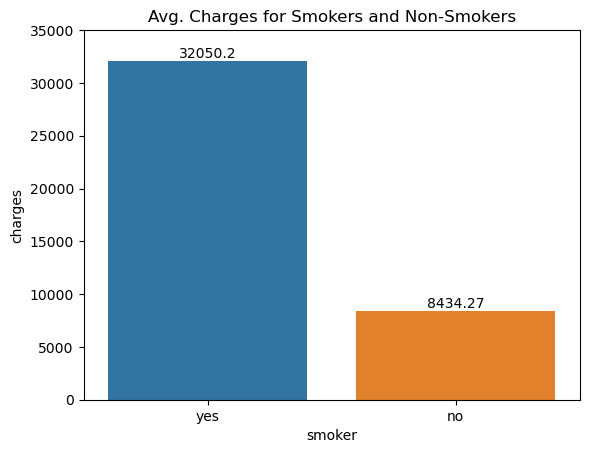

In [18]:
#Visual showing differences in average charges between groups
ax = sns.barplot(data= df, x= 'smoker', y='charges', errwidth=0)
ax.set_title('Avg. Charges for Smokers and Non-Smokers')
for i in ax.containers:
    ax.bar_label(i,);

 ## Q2. Are men more likely to smoke than women?

### Hypothesis: 

- H<sub>0</sub>: There is no relationship between Sex and if someone is a smoker.

- H<sub>a</sub>:A person's Sex influences if they are a Smoker or a Non-Smoker. 
  
### Determine Test Type: 

- We're comparing 2 categorical groups
- We'll run a Chi-Square test.

### Assumptions:
- The outcome is binary (e.g.: two groups, success vs failure)
- The trials/observations are independent


### Testing

In [19]:
#Create contingency table with pd.crosstab()
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [20]:
#Run test
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result 

In [21]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

Note: Because our p-value is less than .05, so we reject the null hypothesis. There is a significant difference between men and women smokers.

### Supporting Visual

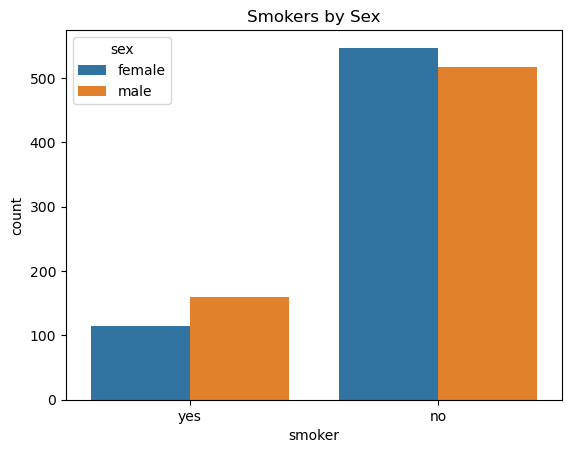

In [22]:
ax = sns.countplot(data= df, x= 'smoker', hue= 'sex')
ax.set_title('Smokers by Sex');

## Q3. Do different regions have different charges, on average?

### Hypothesis: 

- H<sub>0</sub>: There is no relationship between Regions and charges.

- H<sub>a</sub>:Region impacts charges. 
  
### Determine Test Type: 
- Numerical Data
- More than two groups/samples
- We want to run an ANOVA test.

### Assumptions:
- Normality
- Equal variance
- No significant outliers

### Test assumptions

In [23]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [24]:
# Check for outliers
## Loop through groups dict
for sector, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {sector} group.")

    ## Remove the outiers from data and overwrite the sector data in the dict
    data = data.loc[~outliers]
    groups[sector] = data

There were 8 outliers in the southwest group.
There were 2 outliers in the southeast group.
There were 7 outliers in the northwest group.
There were 4 outliers in the northeast group.


In [25]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


In [26]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,318.0,2.940543e-19,85.341045,True
northeast,320.0,3.557877e-17,75.749565,True


### Testing assumption of equal variance

In [27]:
stats.levene(*groups.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

We met the assumption of equal variance.

### Run One-Way ANOVA Test

In [28]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=5.496394682506454, pvalue=0.0009419710075537749)

There is a significant relationship. 

We need to compare every group against every other group and return a p-value for every possible combination of groups

In [29]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as charges and the labels to the region
values = df['charges']
labels = df['region']

In [30]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


Our test show that there is a significant difference in the results of the southeast region compared to the southwest region. 

### Supporting Visual

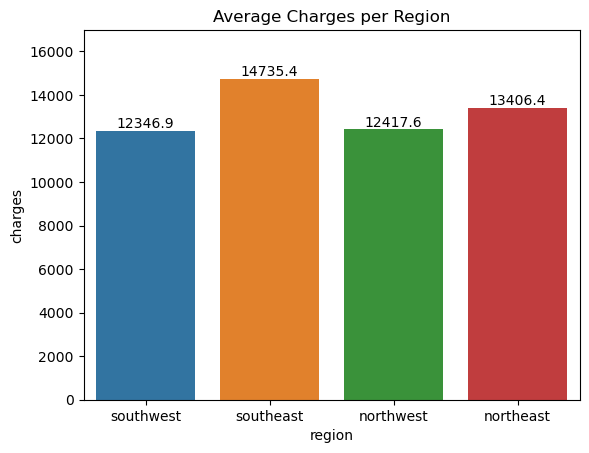

In [31]:
ax = sns.barplot(data= df, x= 'region', y= 'charges', errwidth=0)
ax.set_title('Average Charges per Region');
for i in ax.containers:
    ax.bar_label(i,);